# Source contributions

In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import datetime as dt
import os
from itertools import compress
from mpl_toolkits.basemap import Basemap

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model result set:
folder_base = '/data/brogalla/run_storage/Pb-reference-202303/'

colors  = ['#bea385','#bea385','#bacbda','#bacbda','#a0a3a3','#67b1b5','#2d7073','#a06c50']#'#7b5a48' '#337d80'
land_color         = '#a9a7a2'
land_outline_color = '#373736'

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

#### Load files:

In [4]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
land_mask    = np.ma.masked_where((tmask_sub[:,:,:] > 0.1), tmask_sub[:,:,:]) 
tmask_month  = np.tile(tmask_sub, (12,1,1,1))

mesh       = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e1t_base   = mesh['e1t'].values[0,imin:imax,jmin:jmax]
e2t_base   = mesh['e2t'].values[0,imin:imax,jmin:jmax]
e3t        = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)
nav_lev    = mesh['nav_lev'].values
lons       = mesh['nav_lon'].values

e1t        = np.tile(e1t_base, (50,1,1))
e2t        = np.tile(e2t_base, (50,1,1))
volume     = e1t*e2t*e3t
area_base  = e1t_base*e2t_base
volume_month  = np.tile(volume, (12,1,1,1))
volume_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), area_base)
volume_month_masked = np.ma.masked_where((tmask_month[:,:,:,:] < 0.1), volume_month)

Find grid cell volume and thickness at ocean floor:

In [5]:
tmask_bot = np.copy(tmask_sub)
tmask_bot[0,:,:] = 1
e3t_mask = np.ma.masked_where((tmask_bot[:,:,:] < 0.1), e3t[:,:,:])

# find bottom grid cell index:
ind = np.array(np.ma.notmasked_edges(e3t_mask[:,:,:], axis=0))

# array of shape (isize, jsize) containing bottom grid cell index
index_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1), ind[1][0][:].reshape(isize,jsize))

In [6]:
e3t_bot = np.zeros((isize,jsize))
vol_bot = np.zeros((isize,jsize))

for i in range(0, isize):
    for j in range(0,jsize):
        k = index_bottom[i,j]
        try:
            e3t_bot[i,j] = e3t[k,i,j]
            vol_bot[i,j] = volume[k,i,j]
        except:
            e3t_bot[i,j] = np.nan
            vol_bot[i,j] = np.nan
        
e3t_bottom    = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(e3t_bot), e3t_bot)
volume_bottom = np.ma.masked_where((tmask_sub[0,:,:] < 0.1) | np.isnan(vol_bot), vol_bot)

#### Functions:

Compare values from monthly output for dust with the forcing field that I'm applying.

In [7]:
def load_results(folder, year, experiment):
    
    dpb_riv     = np.empty((12,isize,jsize)); dpb_sed = np.empty((12,isize,jsize)); 
    dpb_atmdust = np.empty((12,isize,jsize)); dpb_atmbc = np.empty((12,isize,jsize)); 
    dpb_icedust = np.empty((12,isize,jsize)); dpb_icebc = np.empty((12,isize,jsize));
    dpb_sedice  = np.empty((12,isize,jsize)); dpb_priv = np.empty((12,isize,jsize));
    dpb_ads     = np.empty((12,50,isize,jsize));
    
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_riv[i,:,:]     = file['dpbriv'].values[0,:,:]
            dpb_priv[i,:,:]    = file['ppbriv'].values[0,:,:]
            dpb_sed[i,:,:]     = file['dpbsed'].values[0,:,:]
            dpb_sedice[i,:,:]  = file['dpbsedice'].values[0,:,:]
            dpb_atmdust[i,:,:] = file['dpbatmdust'].values[0,:,:]
            dpb_atmbc[i,:,:]   = file['dpbatmbc'].values[0,:,:]
            dpb_icedust[i,:,:] = file['dpbicedust'].values[0,:,:]
            dpb_icebc[i,:,:]   = file['dpbicebc'].values[0,:,:]
            dpb_ads[i,:,:,:]   = file['dpbads'].values[0,:,:,:]
    if experiment=='nospm':
        dpb_priv[:,:,:]   =  0
    elif experiment=='noice':
        dpb_sedice[:,:,:] = 0
    elif experiment=='noresus':
        dpb_sed[:,:,:]    = 0

    return dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads

In [8]:
def calculate_contribution(folder, year=2002, experiment='ref', volume_masked=volume_masked, 
                                   volume_month_masked=volume_month_masked, volume_bottom=volume_bottom):
    # Calculate the contribution of the model components
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year, experiment)
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    # Calculate contributions to the upper water column, so mask locations where sediment resuspension is added in the deep.
#     resus   = np.ma.masked_where(np.tile(index_bottom, (12,1,1)) > 19, dpb_sed) * volume_bottom * 1e3
#     resus   = np.ma.masked_where(np.tile(index_bottom, (12,1,1)) > 49, dpb_sed) * volume_bottom * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': 0, 'atm_bc': 0, 'ice_dust': 0, 'ice_bc': 0, 
                    'runoff'  : 0, 'part_runoff': 0, 'resus': 0, 'sed_ice': 0, 'adsorp': 0};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust']    = total_yearly['atm_dust']    + np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc']      = total_yearly['atm_bc']      + np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust']    = total_yearly['ice_dust']    + np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc']      = total_yearly['ice_bc']      + np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff']      = total_yearly['runoff']      + np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'] = total_yearly['part_runoff'] + np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus']       = total_yearly['resus']       + np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice']     = total_yearly['sed_ice']     + np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp']      = total_yearly['adsorp']      + np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
    
    # Average yearly contribution over domain: moles / m2 / year
    ave_yearly = total_yearly.copy()
    for key in ave_yearly:
        ave_yearly[key] = ave_yearly[key]/np.ma.sum(area_masked[:,:])
 
    return total_yearly, ave_yearly

In [9]:
def calculate_contribution_monthly(folder, year=2002, volume_masked=volume_masked, 
                                   volume_month_masked=volume_month_masked, volume_bottom=volume_bottom):
    # Calculate the contribution of the model components
    
    # load contributions from file
    dpb_riv, dpb_priv, dpb_sed, dpb_sedice, dpb_atmbc, dpb_atmdust, dpb_icebc, dpb_icedust, dpb_ads = \
                       load_results(folder, year, 'ref')
    
    tmask_surf    = np.empty(dpb_riv.shape)
    tmask_surf[:] = tmask_sub[0,:,:]
    
    # Momentary contribution: moles / second (from moles / L / s --> moles / m3 / s --> moles / s)
    # Mask is for the points associated with the specified region. 
    priv    = np.ma.masked_where((tmask_surf < 0.1), dpb_priv)    * volume_masked[0,:,:] * 1e3
    riv     = np.ma.masked_where((tmask_surf < 0.1), dpb_riv)     * volume_masked[0,:,:] * 1e3
    sedice  = np.ma.masked_where((tmask_surf < 0.1), dpb_sedice)  * volume_masked[0,:,:] * 1e3
    atmdust = np.ma.masked_where((tmask_surf < 0.1), dpb_atmdust) * volume_masked[0,:,:] * 1e3
    atmbc   = np.ma.masked_where((tmask_surf < 0.1), dpb_atmbc)   * volume_masked[0,:,:] * 1e3
    icedust = np.ma.masked_where((tmask_surf < 0.1), dpb_icedust) * volume_masked[0,:,:] * 1e3
    icebc   = np.ma.masked_where((tmask_surf < 0.1), dpb_icebc)   * volume_masked[0,:,:] * 1e3
    resus   = dpb_sed * volume_bottom * 1e3
    adsorp  = dpb_ads * volume_month_masked[:,:,:,:] * 1e3 #np.ma.masked_where((tmask_month < 0.1) , dpb_ads)    * volume_month_masked[:,:,:,:] * 1e3
    
    # Yearly contribution to domain: moles / year (from moles / s / month --> moles / month --> moles / year)
    total_yearly = {'atm_dust': np.zeros(12), 'atm_bc': np.zeros(12), 'ice_dust': np.zeros(12), 'ice_bc': np.zeros(12), 
                    'runoff'  : np.zeros(12), 'part_runoff': np.zeros(12), 'resus': np.zeros(12), 'sed_ice': np.zeros(12), 
                    'adsorp'  : np.zeros(12)};
    for month in range(1,13):  
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        dt            = 3600*24*days_in_month
        
        total_yearly['atm_dust'][month-1]    = np.ma.sum(atmdust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['atm_bc'][month-1]      = np.ma.sum(atmbc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['ice_dust'][month-1]    = np.ma.sum(icedust[month-1,:,:],axis=(0,1)) * dt
        total_yearly['ice_bc'][month-1]      = np.ma.sum(icebc[month-1,:,:],axis=(0,1))   * dt
        total_yearly['runoff'][month-1]      = np.ma.sum(riv[month-1,:,:],axis=(0,1))     * dt
        total_yearly['part_runoff'][month-1] = np.ma.sum(priv[month-1,:,:],axis=(0,1))    * dt
        total_yearly['resus'][month-1]       = np.ma.sum(resus[month-1,:,:],axis=(0,1))   * dt
        total_yearly['sed_ice'][month-1]     = np.ma.sum(sedice[month-1,:,:],axis=(0,1))  * dt
        total_yearly['adsorp'][month-1]      = np.ma.sum(adsorp[month-1,:,:,:],axis=(0,1,2)) * dt
 
    return total_yearly

In [10]:
def print_interannual_averages(totals, averages):
    keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff', 'resus']
    
    strlen=55; # For print statement formatting
    
    print(f'Interannual average values')
    print('----------------------------------------------------------------')    
    total_annual = sum([totals[key] for key in keys])# exclude adsorption from total
    
    # Total annual contribution is averaged over the 18-year time series and multiplied by 1e-6 to convert to Mmol
    print(f"{'Total annual contribution of Pb [Mmol/yr]:':<{strlen}}"     + f" {np.average(total_annual)         *1e-6:<8.2f}")
    print(f"{'Total annual removal by adsorption [Mmol/yr]:':<{strlen}}"  + f" {np.average(totals['adsorp'])     *1e-6:<8.2f}") 
    print(f"{'-- Dissolved runoff':<{strlen}}"                            + f" {np.average(totals['runoff'])     *1e-6:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff':<{strlen}}"       + f" {np.average(totals['part_runoff'])*1e-6:<8.2f}")
    print(f"{'-- Sediment resuspension':<{strlen}}"                       + f" {np.average(totals['resus'])      *1e-6:<8.2f}")
    print(f"{'-- Sediment released by sea ice':<{strlen}}"                + f" {np.average(totals['sed_ice'])    *1e-6:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice':<{strlen}}"        + f" {np.average(totals['ice_dust'])   *1e-6:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice':<{strlen}}"  + f" {np.average(totals['ice_bc'])     *1e-6:<8.2f}")
    print(f"{'-- Natural aerosol deposition':<{strlen}}"                  + f" {np.average(totals['atm_dust'])   *1e-6:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition':<{strlen}}"            + f" {np.average(totals['atm_bc'])     *1e-6:<8.2f}") 
 
    # Percent is calculated from sum of component contribution over all months / total contributions over full time period
    tref = np.sum(total_annual)
    print('----------------------------------------------------------------')
    print('Total annual contribution of Pb [%]:') 
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {np.sum(totals['runoff'])     *100/tref:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {np.sum(totals['part_runoff'])*100/tref:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {np.sum(totals['resus'])      *100/tref:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {np.sum(totals['sed_ice'])    *100/tref:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {np.sum(totals['ice_dust'])   *100/tref:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {np.sum(totals['ice_bc'])     *100/tref:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {np.sum(totals['atm_dust'])   *100/tref:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {np.sum(totals['atm_bc'])     *100/tref:<8.2f}")  
#     print(f"{'-- Removal by adsorption ':<{strlen}}"                       + f" {np.sum(totals['adsorp'])     *100/tref:<8.2f}") 

    # Average annual contribution is calculated as an average over the full time series and converted to millimol
    print('----------------------------------------------------------------')
    annual_contr = sum([averages[key] for key in keys])
    print(f"{'Average annual contribution of Pb [nanomol/m2/day]:':<{strlen}}" + 
          f"{np.average(annual_contr)*1e9/365:<8.2f}")
    print(f"{'Average annual removal of Pb [nanomol/m2/day]:':<{strlen}}" + 
          f"{np.average(averages['adsorp'])     *1e9/365:<8.2f}")
    print(f"{'-- Dissolved runoff ':<{strlen}}"                            + f" {np.average(averages['runoff'])     *1e9/365:<8.2f}")
    print(f"{'-- Dissolved-particulate exchange runoff ':<{strlen}}"       + f" {np.average(averages['part_runoff'])*1e9/365:<8.2f}")
    print(f"{'-- Sediment resuspension ':<{strlen}}"                       + f" {np.average(averages['resus'])      *1e9/365:<8.2f}")
    print(f"{'-- Sediment released by sea ice ':<{strlen}}"                + f" {np.average(averages['sed_ice'])    *1e9/365:<8.2f}")
    print(f"{'-- Natural aerosols released by sea ice ':<{strlen}}"        + f" {np.average(averages['ice_dust'])   *1e9/365:<8.2f}")
    print(f"{'-- Anthropogenic aerosols released by sea ice ':<{strlen}}"  + f" {np.average(averages['ice_bc'])     *1e9/365:<8.2f}")
    print(f"{'-- Natural aerosol deposition ':<{strlen}}"                  + f" {np.average(averages['atm_dust'])   *1e9/365:<8.2f}") 
    print(f"{'-- Anthropogenic aerosol deposition ':<{strlen}}"            + f" {np.average(averages['atm_bc'])     *1e9/365:<8.2f}") 

    return

In [11]:
# estimate at a transect at the edge of the boundary
# Need: dPb concentration and flow volume 
# mol/L * m3 / s * 1e3 L/m3 = mol/s * 3600*24*days_in_month = mol / month (sum over year) --> mol/yr *1e-6 = Mmol/yr

def calc_transports(ts):
    # sum over transect
    fday   = np.nansum(ts*1e3*(5*3600*24), axis=(1,2)) # mol m3/L s --> mol /s by multiplying by 1e3 --> mol/5 days
    annual = np.nansum(fday, axis=(0))*1e-6  # mol/yr --> Mmol/yr
    return fday, annual

### Calculations:

In [84]:
# adjust masks based on where the boundary transports are calculated
# l1 = 1150-imin
# l2 = 2168-imin
# r1 = 0
# r2 = 778-jmin
# l1 = 1151-imin; l2 = 2167-imin;
# r1 = 0; r2 = 777-jmin;

# l3 = 0;  l4 = 1473-imin;
# r3 = 0;  r4 = 304-jmin;

l1 = 0; l2 = 2168-imin; 
r1 = 0; r2 = 778-jmin;

l3 = 0;  l4 = 1480-imin;
r3 = 0;  r4 = 304-jmin;

l5 = 0; l6 = 1151-imin;
r5 = 446-jmin; r6 = 673-jmin;

# l5 = 0;  l6 = 230;
# r5 = 510;  r6 = 700;

In [85]:
ind_array = np.zeros(volume_month_masked.shape)
ind_array[:,:,l1:l2,r1:r2] = 1 # include area within boundaries
ind_array[:,:,l3:l4,r3:r4] = 0 # exclude Hudson bay boundary area
ind_array[:,:,l5:l6,r5:r6] = 0 # exclude  Labrador Sea or greenland
volume_month_masked2 = np.ma.masked_where(ind_array==0, volume_month_masked)
volume_masked2       = np.ma.masked_where(ind_array[0,:,:,:]==0, volume_masked)
volume_bottom2       = np.ma.masked_where(ind_array[0,0,:,:]==0, volume_bottom)

In [86]:
timeseries_total    = {}
timeseries_ave      = {}
for ind, year in enumerate(years):
    print(year)
    total_yearly, ave_yearly = calculate_contribution(f'{folder_base}Pb-reference-{year}_20230308/', year=year, \
                                                      experiment='ref',volume_masked=volume_masked2, \
                                                      volume_month_masked=volume_month_masked2, volume_bottom=volume_bottom2)
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total[key] = total_yearly[key]
            timeseries_ave[key]   = ave_yearly[key]
        else:
            timeseries_total[key] = np.append(timeseries_total[key], total_yearly[key])
            timeseries_ave[key]   = np.append(timeseries_ave[key]  , ave_yearly[key])

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [87]:
print_interannual_averages(timeseries_total, timeseries_ave)

Interannual average values
----------------------------------------------------------------
Total annual contribution of Pb [Mmol/yr]:              2.38    
Total annual removal by adsorption [Mmol/yr]:           4.28    
-- Dissolved runoff                                     0.04    
-- Dissolved-particulate exchange runoff                0.90    
-- Sediment resuspension                                0.78    
-- Sediment released by sea ice                         0.14    
-- Natural aerosols released by sea ice                 0.02    
-- Anthropogenic aerosols released by sea ice           0.23    
-- Natural aerosol deposition                           0.01    
-- Anthropogenic aerosol deposition                     0.26    
----------------------------------------------------------------
Total annual contribution of Pb [%]:
-- Dissolved runoff                                     1.69    
-- Dissolved-particulate exchange runoff                37.98   
-- Sediment resuspension  

In [14]:
# total_yearly, ave_yearly = calculate_contribution(f'{folder_base}Pb-reference-{year}_20230308/', year=year, experiment='ref')
# print_annual_averages(total_yearly, ave_yearly)

In [88]:
interannual_nCB = np.empty(len(years))
interannual_wCB = np.empty(len(years))
interannual_HB  = np.empty(len(years))
interannual_LS  = np.empty(len(years))

fday_nCB = np.empty((len(years),73))
fday_wCB = np.empty((len(years),73))
fday_HB  = np.empty((len(years),73))
fday_LS  = np.empty((len(years),73))

for y, year in enumerate(years):
    base = '/ocean/brogalla/GEOTRACES/time-series/Pb-model/Pb-reference-202303-shifted/'
    ts_nCB, ts_wCB, ts_HB, ts_LS = pickle.load(open(f'{base}time-series-{year}.pickle','rb'))  
    
    fday_nCB[y,:], interannual_nCB[y] = calc_transports(ts_nCB) 
    fday_wCB[y,:], interannual_wCB[y] = calc_transports(ts_wCB)
    fday_HB[y,:], interannual_HB[y]  = calc_transports(ts_HB) 
    fday_LS[y,:], interannual_LS[y]  = calc_transports(ts_LS)

In [89]:
print('Addition of Pb from boundaries (Mmol/yr):')
print(f'Northern Canada Basin --- {-interannual_nCB.mean():.3f}')
print(f'Western Canada Basin  --- {-interannual_wCB.mean():.3f}')
print(f'Hudson Bay            --- {interannual_HB.mean():.3f}')
print(f'Labrador Sea          --- {interannual_LS.mean():.3f}')
print(f'Sum: {-interannual_nCB.mean()-interannual_wCB.mean()+interannual_HB.mean()+interannual_LS.mean():.3f}')

Addition of Pb from boundaries (Mmol/yr):
Northern Canada Basin --- 0.224
Western Canada Basin  --- 0.167
Hudson Bay            --- -0.006
Labrador Sea          --- 1.259
Sum: 1.645


### Visualize component contributions over the years

In [68]:
# patterns2=['','xxxxxxx','','xxxxxxx','','', '']
patterns=['','...','','...','','', '','']

keys   = ['atm_dust','atm_bc','ice_dust','ice_bc','sed_ice','runoff','part_runoff', 'resus']
labels = ['Crustal aerosols','Anthro. aerosols','Crustal aerosols from ice','Anthro. aerosols from ice',\
          'Crustal sediments from ice', 'Dissolved runoff','Particle-dissolved runoff', 'Sediment resuspension']

mpl.rcParams['hatch.linewidth'] = 0.8
mpl.rcParams['hatch.color']     = 'k'

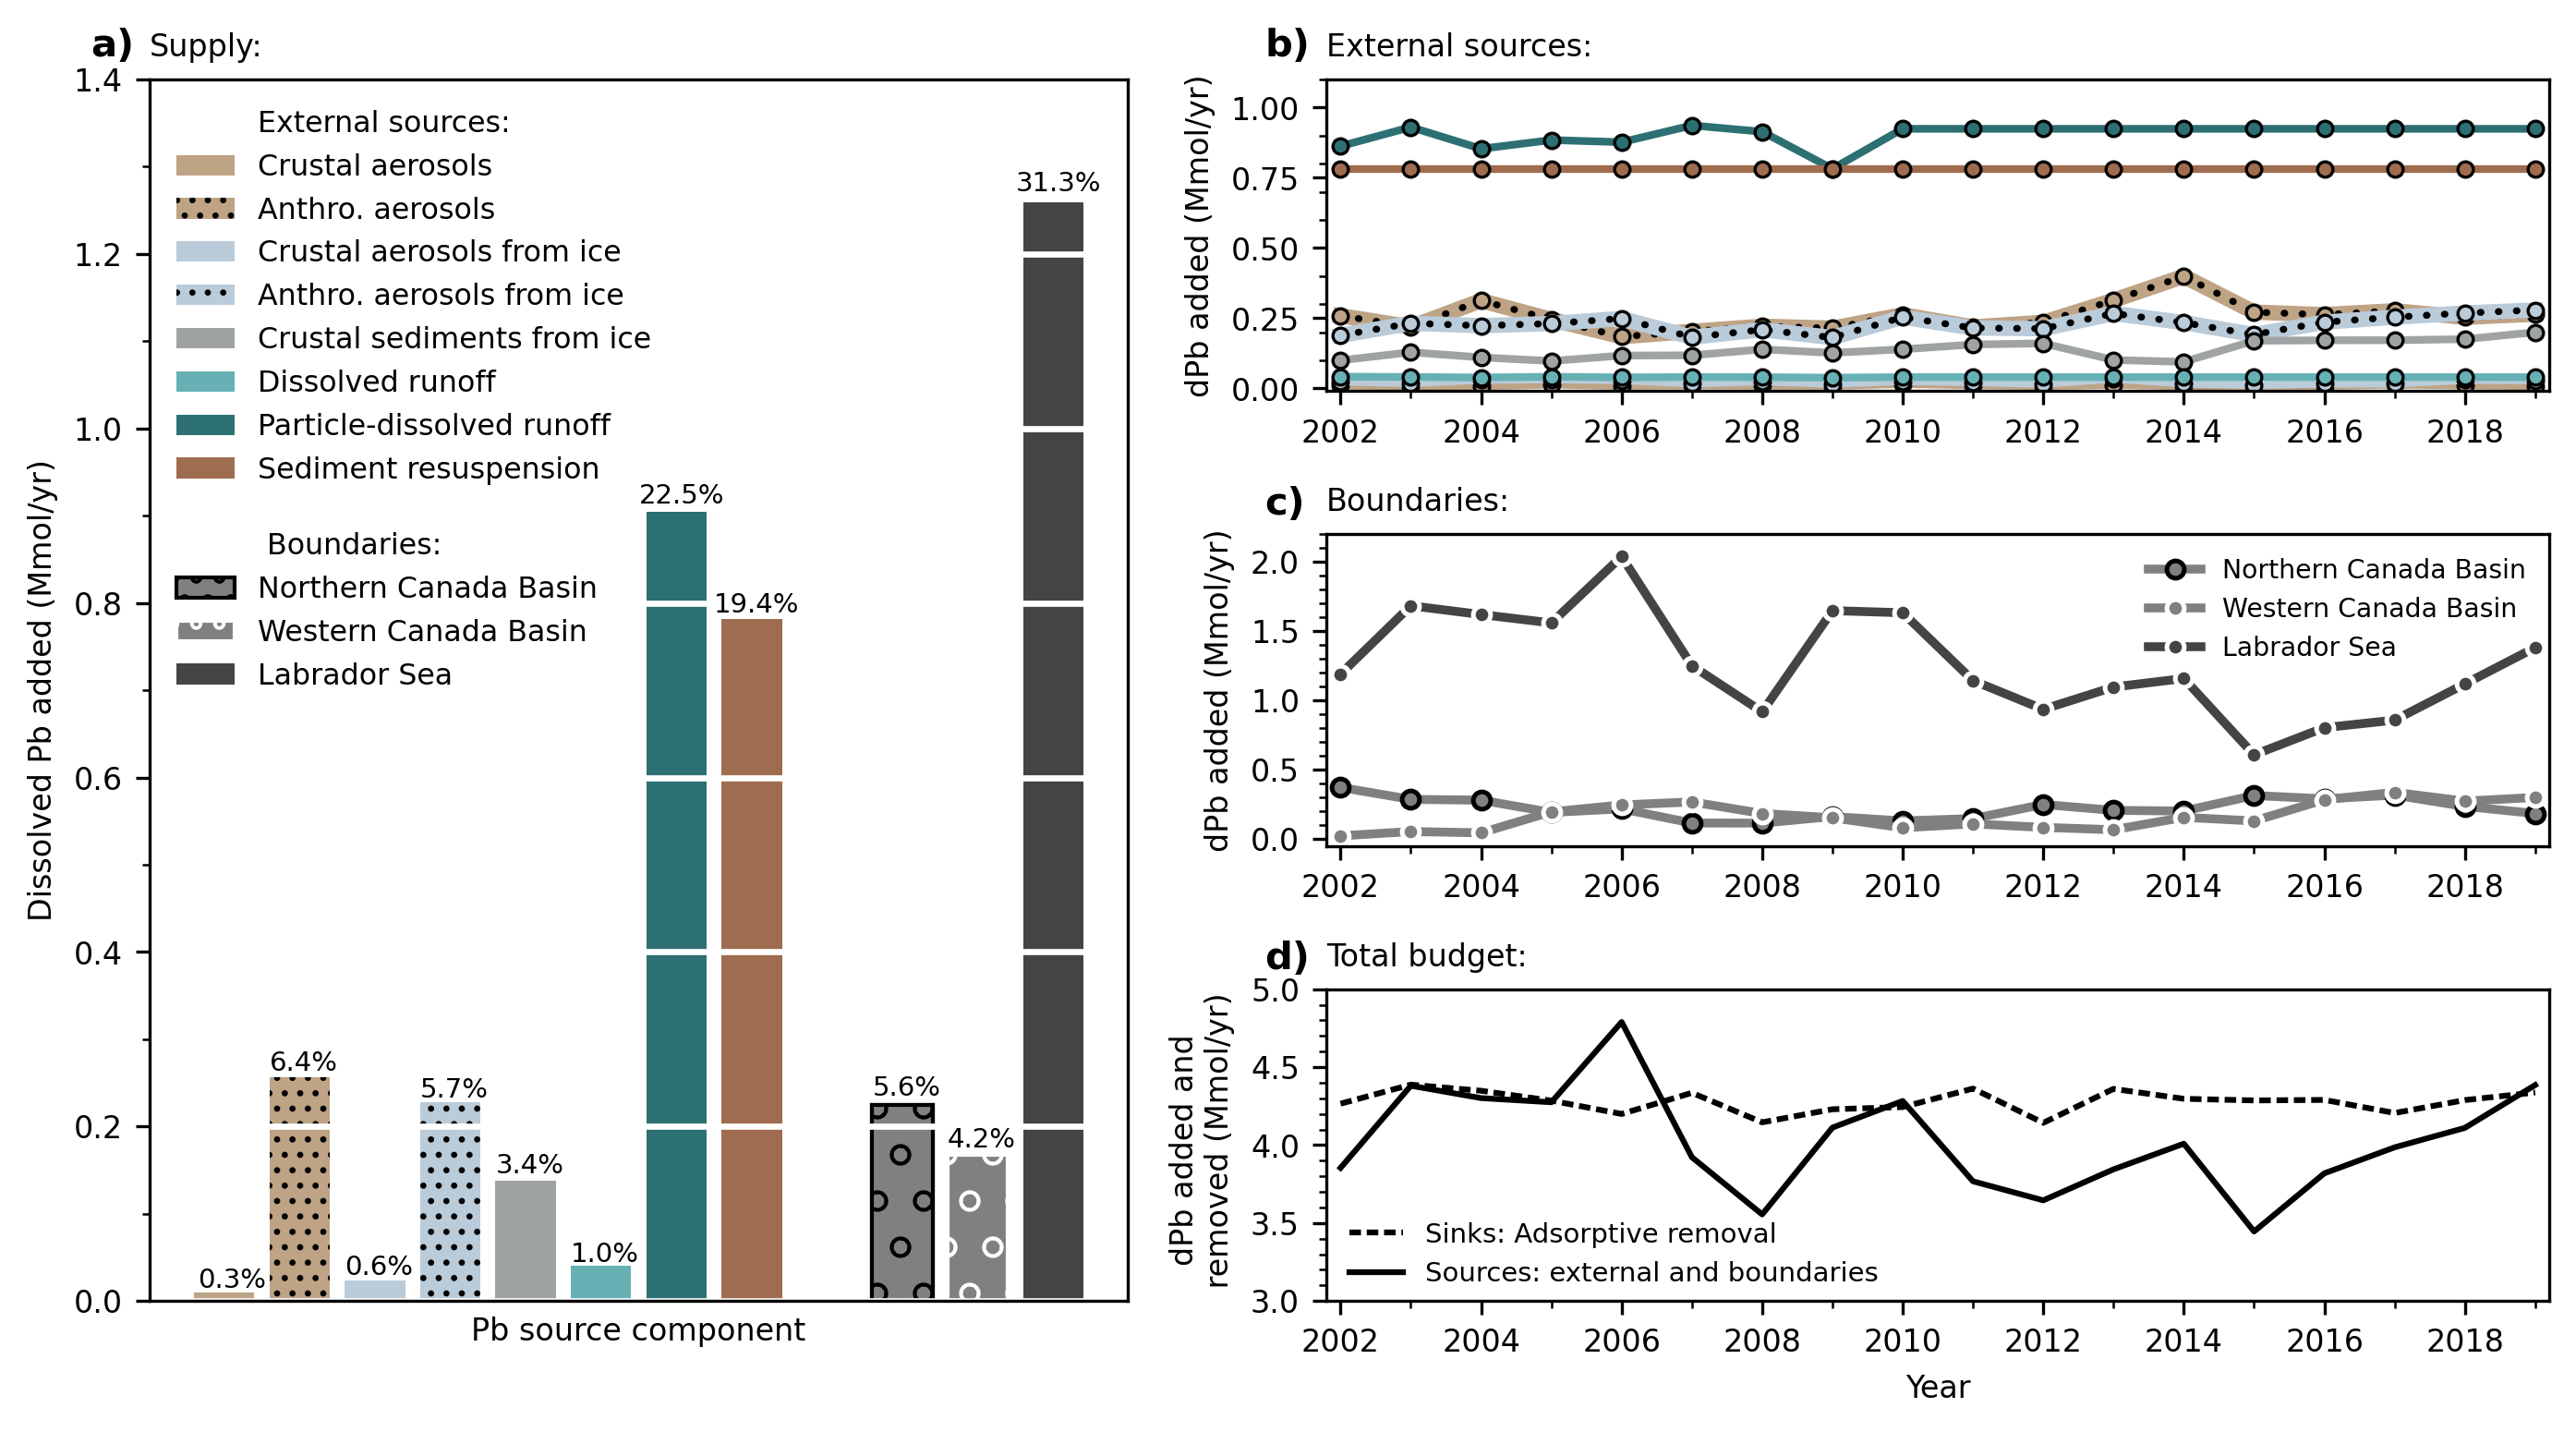

In [93]:
fig = plt.figure(figsize=(4.7*2,3.5*1.5), dpi=300)
gs  = fig.add_gridspec(3,2, width_ratios=[1.6, 2])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 1])

# add percentages:
total   = sum([timeseries_total[key].mean() for key in keys]) + interannual_HB.mean()*1e6 -interannual_nCB.mean()*1e6 \
                -interannual_wCB.mean()*1e6 + interannual_LS.mean()*1e6
percent = [f'{timeseries_total[key].mean()*100/total:.1f}%' for key in keys] + \
          [f'', f'{-interannual_nCB.mean()*100/(total*1e-6):.1f}%', \
           f'{-interannual_wCB.mean()*100/(total*1e-6):.1f}%', f'{interannual_LS.mean()*100/(total*1e-6):.1f}%']
xloc    = [-0.35, 0.6, 1.6, 2.6, 3.6, 4.6, 5.5, 6.5, 7.5, 8.6, 9.6, 10.5]
yloc    = [1.5, 1.03, 1.3, 1.02, 1.06, 1.12, 1.01, 1.01, 1.05, 1.05, 1.05, 1.01]

ax1.plot(0.5,0.5, color='w', label='External sources: ')
for ind, key in enumerate(keys):
    ax1.bar(key, timeseries_total[key].mean()*1e-6, label=labels[ind], width=0.8, color=colors[ind], hatch=patterns[ind])
    ax1.text(xloc[ind], timeseries_total[key].mean()*1e-6*yloc[ind], percent[ind], fontsize=7)
    
    if key=='atm_bc' or key=='ice_bc':
        ax2.plot(years, timeseries_total[key]*1e-6, '-', linewidth=4, color=colors[ind])
        ax2.plot(years, timeseries_total[key]*1e-6, linestyle=(0,(0.1,2.5)), dash_capstyle = 'round',
                  linewidth=1.8, color='k')
        ax2.plot(years, timeseries_total[key]*1e-6, '.', markersize=8, 
                  markeredgecolor='k', markeredgewidth=0.8, color=colors[ind])
    else:
        ax2.plot(years, timeseries_total[key]*1e-6, '.-', markersize=8, linewidth=2.0, 
                  markeredgecolor='k', markeredgewidth=0.8, color=colors[ind])

# Transport via boundaries:
ax1.bar('HB', interannual_HB.mean(), width=0.8, color='w', label='\n Boundaries: ')
ax1.bar('nCB', -interannual_nCB.mean(), width=0.8, color='gray', label='Northern Canada Basin', hatch='oo', edgecolor='k')
ax1.bar('wCB', -interannual_wCB.mean(), width=0.8, color='gray', label='Western Canada Basin', hatch='oo', edgecolor='w')
ax1.bar('nCB', -interannual_nCB.mean(), width=0.8, color='gray', hatch='o', edgecolor='k')
ax1.bar('wCB', -interannual_wCB.mean(), width=0.8, color='gray', hatch='o', edgecolor='w')
ax1.bar('LS', interannual_LS.mean(), width=0.8, color='#444444', label='Labrador Sea')
ax1.text(xloc[8], interannual_HB.mean()*yloc[8], percent[8], fontsize=7)
ax1.text(xloc[9], -interannual_nCB.mean()*yloc[9], percent[9], fontsize=7)
ax1.text(xloc[10], -interannual_wCB.mean()*yloc[10], percent[10], fontsize=7)
ax1.text(xloc[11], interannual_LS.mean()*yloc[11], percent[11], fontsize=7)

# left plot:
ax1.grid(color='white', axis='y', linewidth=1.6)
ax1.set_xlabel('Pb source component', fontsize=8)
ax1.set_ylabel('Dissolved Pb added (Mmol/yr)', fontsize=8)
ax1.legend(loc=(0.015, 0.49), fontsize=7.6, frameon=False)
ax1.set_ylim(0,1.4)
ax1.set_xticks([])
ax1.set_xticklabels([])

# right plots:
ax3.plot(years, -interannual_nCB, linestyle='solid', linewidth=2.3, marker='.',
         markersize=9, markeredgecolor='k', markeredgewidth=1.2, c='gray', label='Northern Canada Basin')
ax3.plot(years, -interannual_wCB, linestyle='solid', linewidth=2.3, marker='.', 
         markersize=9, markeredgecolor='w', markeredgewidth=1.2, c='gray', label='Western Canada Basin')
ax3.plot(years, interannual_LS  , linestyle='solid', linewidth=2.3, marker='.',
         markersize=9, markeredgecolor='w', markeredgewidth=1.2, c='#444444', label='Labrador Sea')
ax3.legend(fontsize=6.8, frameon=False)

# Total:
total_plot = np.array([timeseries_total[key] for key in keys]).sum(axis=0) \
                -interannual_nCB*1e6 -interannual_wCB*1e6 + interannual_LS*1e6 +interannual_HB*1e6
ax4.plot(years, timeseries_total['adsorp']*1e-6, linewidth=1.5, linestyle=(0,(2,1)), color='k', label = 'Sinks: Adsorptive removal')
ax4.plot(years, total_plot*1e-6, linewidth=1.5, color='k', label = 'Sources: external and boundaries')
ax4.legend(loc=(0.01, 0.01), fontsize=7, frameon=False)
    
ax4.set_xlabel('Year', fontsize=8)
ax2.set_ylim(-0.01, 1.1)
ax3.set_ylim(-0.05, 2.2)
ax4.set_ylim(3.0, 5.0)
for axis in [ax2, ax3, ax4]:
    axis.set_xlim(2001.8,2019.2)
    axis.xaxis.set_major_locator(MultipleLocator(2))
    axis.xaxis.set_minor_locator(MultipleLocator(1))

for axis in [ax1, ax2, ax3, ax4]:
    axis.tick_params(axis='both', labelsize=8)
    axis.yaxis.set_minor_locator(MultipleLocator(0.1))
    
fig.text(0.040, 0.955, 'a)', fontsize=10, weight='bold');
fig.text(0.491, 0.955, 'b)', fontsize=10, weight='bold');
fig.text(0.491, 0.640, 'c)', fontsize=10, weight='bold');
fig.text(0.491, 0.328, 'd)', fontsize=10, weight='bold');

ax1.set_title('Supply:', fontsize=8, loc='left')    
ax2.set_title('External sources:', fontsize=8, loc='left')    
ax3.set_title('Boundaries:', fontsize=8, loc='left') 
ax4.set_title('Total budget:', fontsize=8, loc='left')       

ax2.set_ylabel('dPb added (Mmol/yr)', fontsize=8)
ax3.set_ylabel('dPb added (Mmol/yr)', fontsize=8)
ax4.set_ylabel('dPb added and \n removed (Mmol/yr)', fontsize=8)
plt.tight_layout(h_pad=1)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R4-budget.jpg', dpi=300, bbox_inches='tight')

### Close budget

In [70]:
def load_dissolpb(folder, year):
    
    dpb_array  = np.empty((12,50,isize,jsize));
    for i, month in enumerate(range(1,13)):
        file_name = f'ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
        with xr.open_dataset(folder+file_name) as file:
            dpb_array[i,:,:,:] = file['dissolpb'].values[0,:,:,:]
        
    return dpb_array

#### Calculate % of dPb lost by the end of the time series relative to start

In [71]:
dpb_years = np.zeros((len(years),12))
# Load monthly dPb concentrations at start of time series (year 2002) and end (year 2019):
for n,year in enumerate(years): # moles
    print(year)
    dpb_years[n,:] = np.ma.sum((load_dissolpb(f'{folder_base}Pb-reference-{year}_20230308/', year)*volume_month_masked2*1e3),\
                               axis=(1,2,3))

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [72]:
timeseries_total    = {}
for ind, year in enumerate(years):
    print(year)
    total_yearly = calculate_contribution_monthly(f'{folder_base}Pb-reference-{year}_20230308/', year=year,
                                                 volume_masked=volume_masked2, volume_month_masked=volume_month_masked2,
                                                 volume_bottom=volume_bottom2)
    
    for key in total_yearly:
        if ind ==0:
            timeseries_total[key] = total_yearly[key]
        else:
            timeseries_total[key] = np.append(timeseries_total[key], total_yearly[key])

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [73]:
year_array = np.array(years)

In [74]:
print('Mmol dPb in 2002: ', dpb_years[year_array==2002,0]*1e-6)
print('Mmol dPb in 2019: ', dpb_years[year_array==2019,0]*1e-6)
print('Mmol dPb change: ', dpb_years[year_array==2019,0]*1e-6 - dpb_years[year_array==2002,0]*1e-6)
print('Change in %: ', 100-np.ma.sum(dpb_years[year_array==2019,11]*1e-6)*100/np.ma.sum(dpb_years[year_array==2002,0]*1e-6))

Mmol dPb in 2002:  [29.16778316]
Mmol dPb in 2019:  [25.52571012]
Mmol dPb change:  [-3.64207304]
Change in %:  12.439832720940998


#### Calculate the sum of the sources and the sum of the sinks and compare with the % lost with that calculated above

In [75]:
sources    = np.array([timeseries_total[key] for key in keys]).sum(axis=0) 
transports_yearly = -interannual_nCB*1e6 -interannual_wCB*1e6 + interannual_LS*1e6 + interannual_HB*1e6
transports_fday   = -fday_nCB -fday_wCB + fday_LS + fday_HB
sinks             = timeseries_total['adsorp']

In [76]:
dateP_list = []
for year in years:
    dpb_file_list = np.sort(os.listdir(f'{folder_base}Pb-reference-{year}_20230308/'))
    gridP_list = list(compress(dpb_file_list, [i[35:39]=='ptrc'  for i in dpb_file_list]))
    dateP_list = dateP_list + [dt.datetime.strptime(i[51:59], "%Y%m%d")    for i in gridP_list]

In [77]:
dates     = pd.date_range(f'{years[0]}-01-01',f'{years[-1]}-12-31',freq='MS')
plt_years = pd.date_range(f'{years[0]}-12-31',f'{years[-1]}-12-31',freq='Y')
plt_fday  = pd.DatetimeIndex(dateP_list) 

In [78]:
transport_monthly = np.empty((len(years),12));
transport_monthly_nCB = np.empty((len(years),12)); transport_monthly_wCB = np.empty((len(years),12));
transport_monthly_LS  = np.empty((len(years),12)); transport_monthly_HB  = np.empty((len(years),12));

for y, year in enumerate(years):
    for m, month in enumerate(range(1,13)):
        days_in_month = monthrange(year, month)[1]
        if days_in_month == 29: days_in_month = 28 # ignore leap year
        
        transport_monthly[y,m]     = np.mean(transports_fday.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_nCB[y,m] = np.mean(fday_nCB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_wCB[y,m] = np.mean(fday_wCB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_LS[y,m]  = np.mean(fday_LS.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5
        transport_monthly_HB[y,m]  = np.mean(fday_HB.flatten()[(plt_fday.year==year) & (plt_fday.month==month)])*days_in_month/5

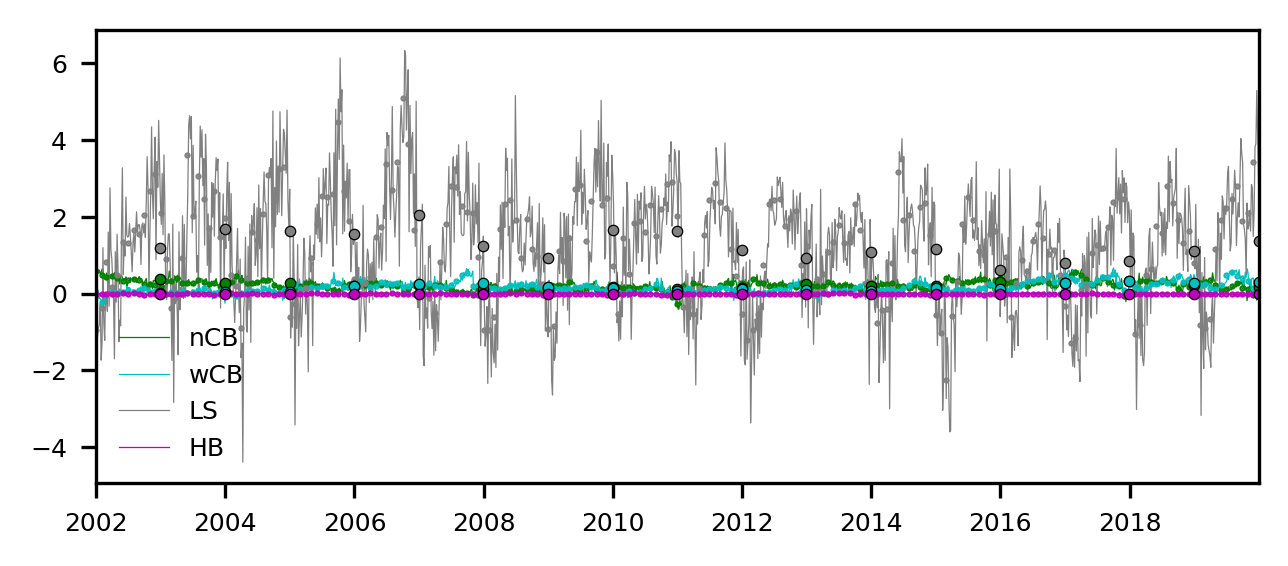

In [43]:
fig, ax = plt.subplots(1,1, figsize=(5,2), dpi=300)
ax.tick_params(axis='both', labelsize=6)

ax.plot(plt_fday, -fday_nCB.flatten()*1e-6*365/5, label='nCB', linewidth=0.3, color='g')
ax.plot(plt_fday, -fday_wCB.flatten()*1e-6*365/5, label='wCB', linewidth=0.3, color='c')
ax.plot(plt_fday, fday_LS.flatten()*1e-6*365/5, label='LS', linewidth=0.3, color='gray')
ax.plot(plt_fday, fday_HB.flatten()*1e-6*365/5, label='HB', linewidth=0.3, color='m')

ax.plot(dates, -transport_monthly_nCB.flatten()*1e-6*12, '.', color='g', markersize=1)
ax.plot(dates, -transport_monthly_wCB.flatten()*1e-6*12, '.', color='c', markersize=1)
ax.plot(dates, transport_monthly_LS.flatten()*1e-6*12, '.', color='gray', markersize=1)
ax.plot(dates, transport_monthly_HB.flatten()*1e-6*12, '.', color='m', markersize=1)

ax.plot(plt_years, -interannual_nCB,'.', color='g', markersize=5, markeredgecolor='k', markeredgewidth=0.3)
ax.plot(plt_years, -interannual_wCB,'.', color='c', markersize=5, markeredgecolor='k', markeredgewidth=0.3)
ax.plot(plt_years, interannual_LS,'.', color='gray', markersize=5, markeredgecolor='k', markeredgewidth=0.3)
ax.plot(plt_years, interannual_HB,'.', color='m', markersize=5, markeredgecolor='k', markeredgewidth=0.3)

ax.set_xlim(dates[0],plt_years[-1])
ax.legend(fontsize=6, frameon=False)

In [79]:
print(np.sum(transports_yearly))
print(np.sum(transports_fday))
print(np.sum(transport_monthly))
# transports are identical in the end

29608873.77974093
29608873.77974093
29663802.181918822


#### Try to actually close the budget based on the moles of Pb

The offset must have something to do with the transport at the boundaries

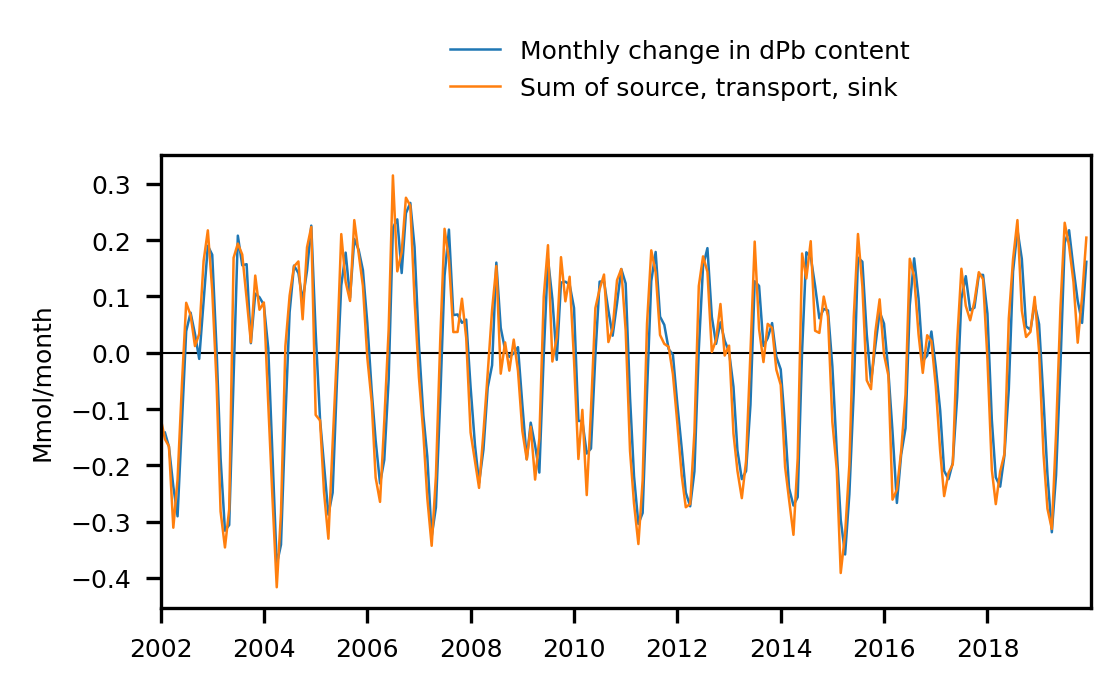

In [80]:
fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags1={'linewidth':0.6, 'linestyle':'-'}

ax.plot(dates[1:], np.diff(dpb_years.flatten())*1e-6, label='Monthly change in dPb content', **kwags1)
ax.plot(dates, (sources + transport_monthly.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags1)

ax.set_xlim(dates[0],plt_years[-1])
ax.set_ylabel('Mmol/month', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

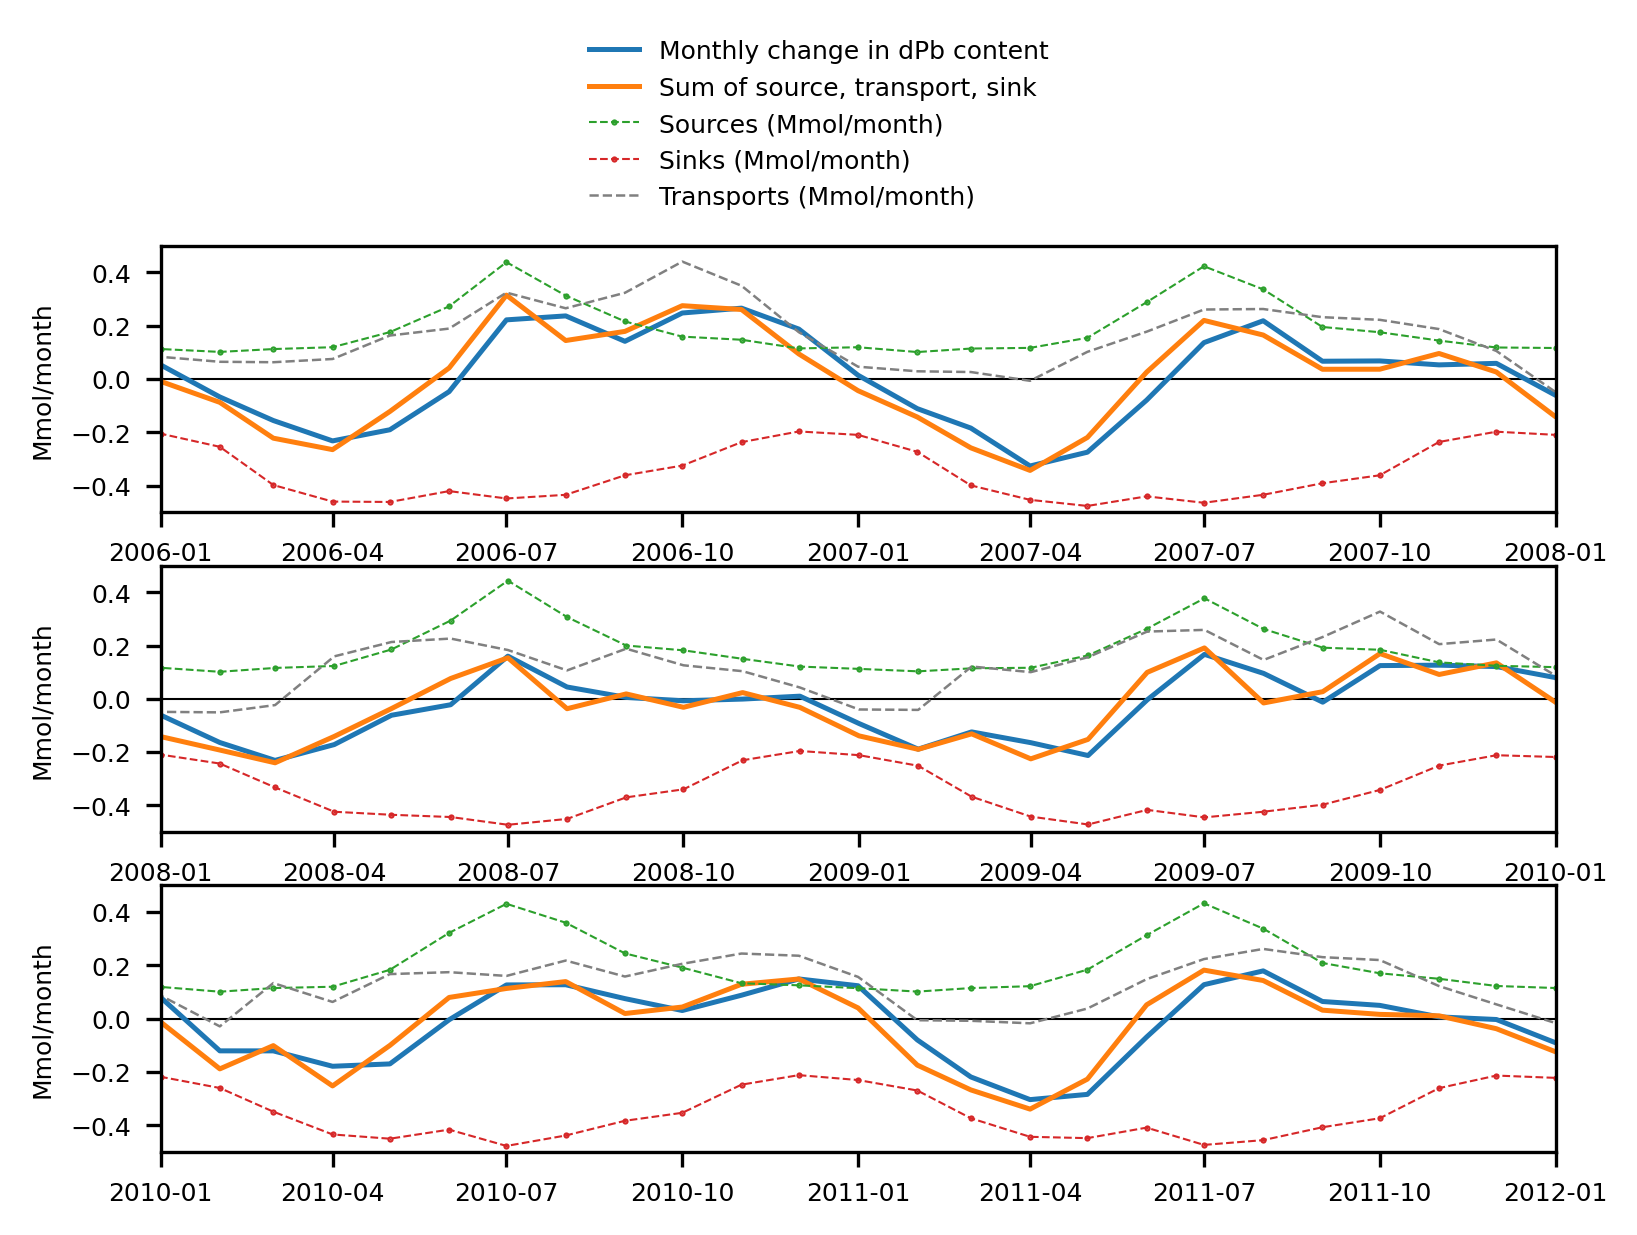

In [81]:
fig, ax = plt.subplots(3,1,figsize=(6,4), dpi=300)

kwags={'linewidth':0.5, 'markersize':1, 'linestyle':'--', 'marker':'.'}
kwags1={'linewidth':1.2, 'linestyle':'-'}

for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)
    axis.set_ylabel('Mmol/month', fontsize=6)
    axis.set_ylim(-0.5,0.5)
    axis.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

    axis.plot(dates[1:], np.diff(dpb_years.flatten())*1e-6, label='Monthly change in dPb content', **kwags1)
    axis.plot(dates, (sources + transport_monthly.flatten() - sinks)*1e-6, label='Sum of source, transport, sink', **kwags1)
    
    axis.plot(dates, sources*1e-6, label='Sources (Mmol/month)', **kwags)
    axis.plot(dates, -sinks*1e-6, label='Sinks (Mmol/month)', **kwags)
    axis.plot(dates, transport_monthly.flatten()*1e-6, '--', linewidth=0.6, c='gray', label='Transports (Mmol/month)')
#     axis.plot(plt_fday, transports_fday.flatten()*6*1e-6, '-', linewidth=0.3, c='gray', label='Transports (Mmol/ 6 five-day files)')

ax[0].set_xlim(pd.Timestamp('2006-01-01'), pd.Timestamp('2008-01-01'))
ax[1].set_xlim(pd.Timestamp('2008-01-01'), pd.Timestamp('2010-01-01'))
ax[2].set_xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2012-01-01'))
# ax.set_xlim(dates[0],plt_years[-1])

ax[0].legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

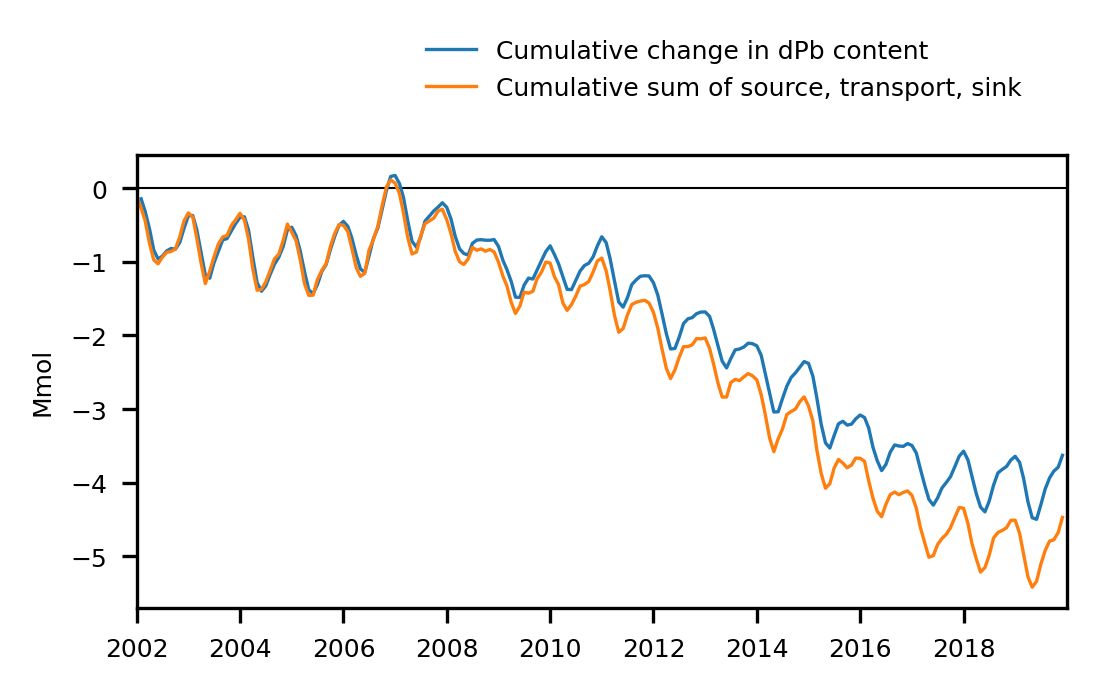

In [82]:
fig, ax = plt.subplots(1,1,figsize=(4,2), dpi=300)

ax.plot([dates[0],plt_years[-1]], [0,0], '-k', linewidth=0.5)

kwags={'linewidth':0.8, 'linestyle':'-'}

ax.plot(dates[1:], np.cumsum(np.diff(dpb_years.flatten()))*1e-6, label='Cumulative change in dPb content', **kwags)
# ax.plot(dates[1:], np.cumsum((sources[1:]+ transport_monthly.flatten()[1:] - sinks[1:]))*1e-6, \
#         label='Cumulative sum of source, transport, sink', **kwags)

ax.plot(dates, np.cumsum((sources+ transport_monthly.flatten() - sinks))*1e-6, \
        label='Cumulative sum of source, transport, sink', **kwags)

ax.set_xlim(dates[0],plt_years[-1])
# ax.set_xlim(dates[0],dates[50])
ax.set_ylabel('Mmol', fontsize=6)

ax.tick_params(axis='both', labelsize=6)

ax.legend(loc=(0.3, 1.1), fontsize=6, frameon=False)

In [83]:
print((np.sum(np.diff(dpb_years.flatten())) - np.sum((sources[1:] + transport_monthly.flatten()[1:] - sinks[1:])))*1e-6)

0.7280362695225887
